# Preprocessing training and testing data for regression

### Example using the preprocess_train and preprocess_test functions in the PyMLR module

The PyMLR module includes two functions for preprocessing data used for regression:

- **preprocess_train** is used to preprocess the training data subset
- **preprocess_test** is used to preprocess the testing data subset using the same scaler and encoder that was on the training data subset

The best practice for scaling and encoding data is to use the training data subset to create the scale and encoder. In order to prevent data leakage between the train and test subsets, it is best if the test data subset is not used to create the scaler and encoder. It is important to use the same scaler on the test subset that was trained on the train subet.

#### Identify the various kinds of data in the features dataframe:

In this example, we will show how use the preprocess_results output from **preproces_train** to identify the following types of data features:

- continous_cols are the continuously varying numeric columns
- categorical_numeric are the numeric columns that have less than or equal to a specified threshold number of unique values (default: 12)
- non_numeric_cats are the non-numeric columns that will be assumed to be categorical
- bool_cols are the boolean data columns that will be assumed to be categorical
- categorical_cols = categorical_numeric + non_numeric_cats + bool_cols 

The **preprocess_train** automatically uses OneHotEncoder on all categorical_cols. Therefore, all binary and multiclass categorical columns, whether they are categorical_numeric or non_numeric_cats, are separated into binary columns with values of 0 or 1. All continuous_cols are automatically scaled with StandardScaler.

The user also has the option to identify positively and negatively skewed continuous_cols. If the input argument unskew_pos=True, then log1p transform is used on postively skew features. If unskew_neg=True, then the sqrt transform is used on negatively skewed features. Both of these arguments are False by default. We will explore using True for both of these to see the effect of unskewing the data features. With this option the unskewing transformations are applied before the continuous_cols are scaled.

The skewed columns are identified in preprocess_result as follows whether or not unskew_pos and unskew_neg arguments are True or False. It us up to the user to optionally specify whether the skewed features should be unskewed during preprocessing. The following outputs are contained in the preprocess_result of **preprocess_train**:

- skewed_pos_cols is a list of columns that are postively skewed
- skewed_neg_cols is a list of columns that are negativel skewed
- skew_df is a dataframe of the skew value for each column in continuous_cols

#### Input arguments for preprocess_train

    Args:
        df (pd.DataFrame): Training data 
            (if df is not a dataframe it will be converted to a dataframe)
        kwargs: optional keyword arguments
            threshold_cat (int): Max unique values for numeric columns 
                to be considered categorical (default: 10)
            scale (str): 'minmax' or 'standard' for scaler (default: 'standard')
            unskew_pos (bool): True: use log1p transform on features with 
                skewness greater than threshold_skew_pos (default: False)
            threshold_skew_pos: threshold skewness to log1p transform features
                used if unskew_pos=True (default: 0.5)
            unskew_neg (bool): True: use sqrt transform on features with 
                skewness less than threshold_skew_neg (default: False)
            threshold_skew_neg: threshold skewness to sqrt transform features
                used if unskew_neg=True (default: -0.5)

#### Output from preprocess_train

The output from **preprocess_train**, which we will name **preprocess_result** for consistency with the input argument of **preprocess_test**, contains the following dictionary:

        dict: {
            'df': original data, converted to dataframe if needed
            'df_processed': Preprocessed DataFrame,
            'columns_original': list of column names of original dataframe
            'columns_processed': list of column names of processed dataframe            
            'encoder': Fitted OneHotEncoder or None,
            'scaler': Fitted Scaler or None,
            'continuous_cols': list of continuous numeric columns,
            'categorical_numeric': list of categorical numeric columns,
            'non_numeric_cats': list of non_numeric categorical columns,
            'bool_cols': list of boolean columns,
            'categorical_cols': list of all categorical columns,
            'datetime_cols': list of datetime columns,
            'category_mappings': Mapping of categories or {},
            'threshold_skew_pos': same as input threshold_skew_pos,
            'threshold_skew_neg': same as inpt threshold_skew_neg,
            'skew_df': dataframe of skew of each feature in continuous_col,
            'skewed_pos_cols': list of candidate features for positive unskewing, 
            'skewed_neg_cols': list of candidate features for negative unskewing,
            'unskew_pos': True if candidate features for positive unskewing were unskewed,
            'unskew_neg': True if candidate features for negative unskewing were unskewed
        }

#### Input arguments for preprocess_test

    Args:
        df_test (pd.DataFrame): Input test DataFrame 
            if df_test is not a dataframe it will be converted to dataframe
        preprocess_result (dict): Output dictionary from preprocess_train

#### Output from preprocess_test

    Returns:
        pd.DataFrame: Preprocessed test DataFrame

#### Preprocessing steps in cross-validated model optimization

This example also shows how to use **preprocess_train** and **preprocess_test** functions as standalone functions for exploratory data analysis in a workflow with cross-validation to train and test a model before fitting the final model with all of the data. The **preprocess_train** function can be used as a standalone function for optional exploratory data analysis, or the exploratory analysis can be skipped and **preprocess_train** can simply be used automatically (by default) during the model training with each of the PyMLR regression functions. 

#### Example data set

In this notebook, we will use the dataset known as the “Ames housing dataset”. This dataset can be fetched from internet using scikit-learn.

https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_ames_housing.html

# Load and clean the Ames housing data set

The Ames housing dataset contains some columns with nan values. For simlicity of this example we will drop the columns with nan values so that we can focus on showing how to use the preprocess_train and preprocess_test functions.

In this section we will load the Ames housing dataset into a pandas dataframe X for features and a pandas series y for the response variable. 

In [1]:
# load the full dataset

from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True, parser='auto')

In [2]:
# Load the X dataframe of features

X = housing.data.copy(deep=True) # create new DataFrame copy of original dataset
X = X.astype({'Id': int})       # set data type of Id to int
X = X.set_index('Id')           # set Id column to be the index of the DataFrame
print(X.shape)
X.head()                                # evaluate result

(1460, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


The following section shows that X contains a variety of dtypes including float, int, object (strings). Many of the number dtypes can also be considered to be categorical. In a later section we will use the default (threshold_cat= 12) to separate the number dtypes into categorical_numeric (if the number of unique items is <= threshold_cat) or continuous_cols (if the number of unique items is > threshold_cat). The categorical_numeric features will be included in the categorical_cols that are one-hot encoded. 

The value of threshold_cat can be changed by the user when the **preprocess_train** function is used. For example, to assume that all number features are continuous_cols, the user may specify threshold_cat=0 as an input argument to **preprocess_train**.

In [3]:
# Show the dtype and number of unique items for each feature of X

import pandas as pd

# Display dtype and number of unique values for each column
result = X.apply(lambda col: pd.Series({'dtype': col.dtype, 'unique_values': col.nunique()}))

with pd.option_context('display.max_rows', None):
    print(result.T)

                 dtype unique_values
MSSubClass       int64            15
MSZoning        object             5
LotFrontage    float64           110
LotArea          int64          1073
Street          object             2
Alley           object             2
LotShape        object             4
LandContour     object             4
Utilities       object             2
LotConfig       object             5
LandSlope       object             3
Neighborhood    object            25
Condition1      object             9
Condition2      object             8
BldgType        object             5
HouseStyle      object             8
OverallQual      int64            10
OverallCond      int64             9
YearBuilt        int64           112
YearRemodAdd     int64            61
RoofStyle       object             6
RoofMatl        object             8
Exterior1st     object            15
Exterior2nd     object            16
MasVnrType      object             4
MasVnrArea     float64           327
E

In [4]:
# Optional exploration - uncomment the code below show the maximum number of items in columns with <100 unique items

'''
unique_counts = []
for col in X.columns:
    unique_count = X[col].nunique()
    if unique_count < 100:
        unique_counts.append(unique_count)
        print(f"Column: {col}, Dtype: {df[col].dtype}, Unique Items: {unique_count}")
print(f'The maximum number of unique items for features with <50 unique items is {max(unique_counts)}')
''';

# Drop X columns with nan

We will simply drop columns from X that contain nan values to clean the data for use in the preprocess workflow. In a real world applications the user may want to spend more time analyzing columns with missing data, but that is not the focus of this example.

In [5]:
# Clean the X data by dropping columns with nan

X = X.dropna(axis=1)
print("There are {0} rows and {1} columns in the X dataframe after removing the columns with nan values"
      .format(X.shape[0],X.shape[1]))

There are 1460 rows and 60 columns in the X dataframe after removing the columns with nan values


# Load the response variable y

The target response variable (sale price) is loaded into a pandas series named y

In [6]:
# load the target response variable (sale price) as pandas series y

import pandas as pd
y = pd.Series(housing.target) # load data into dataframe
y.index = X.index

print(f'Shape of y: {y.shape}')
print(f'Number of nan values in y: {y.isna().sum()}')
y.describe() 

Shape of y: (1460,)
Number of nan values in y: 0


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# Check normality of y

The following QQ plots show that y is log-normal. Therefore we will use the log1p transform of y for the regression

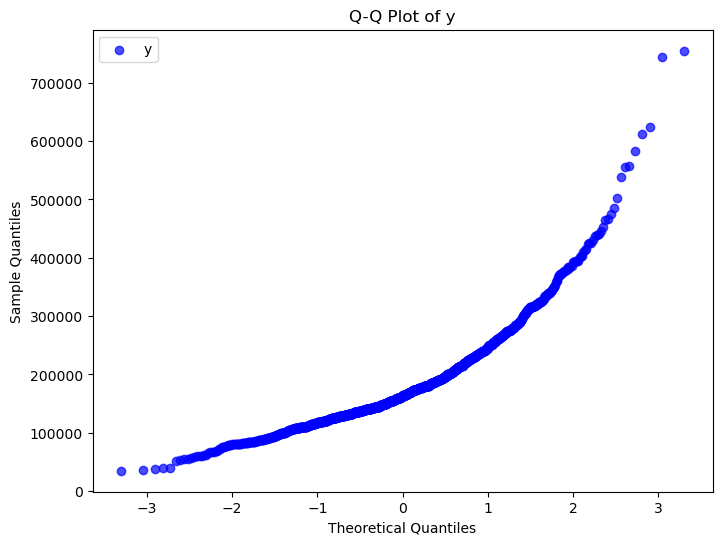

In [7]:
# QQ plot of raw y without transformation

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

data1 = y
data2 = np.log(y)

# Generate Q-Q plot data for both datasets
qq1 = stats.probplot(data1, dist="norm")
qq2 = stats.probplot(data2, dist="norm")

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the dataset
plt.scatter(qq1[0][0], qq1[0][1], color='blue', label='y', alpha=0.7)
# plt.scatter(qq2[0][0], qq2[0][1], color='red', label='log(y)', alpha=0.7, s=10)

# Customize the plot
plt.title('Q-Q Plot of y')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
# plt.grid()
plt.show()

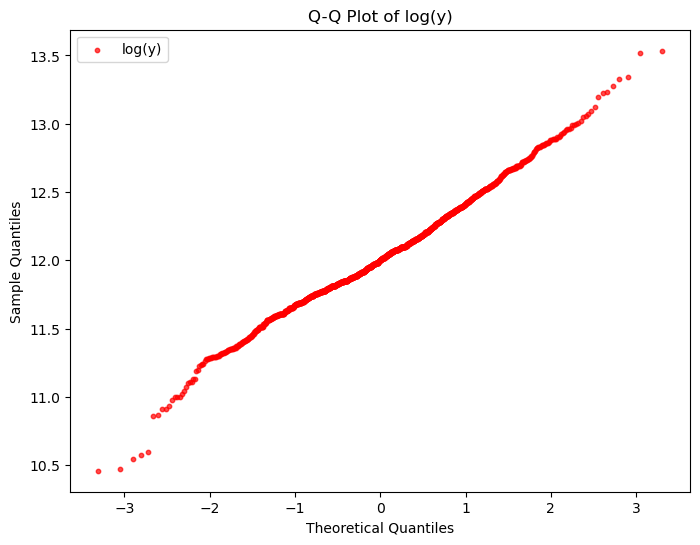

In [8]:
# QQ plot of log1p(y)

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

data1 = y
data2 = np.log(y)

# Generate Q-Q plot data for both datasets
qq1 = stats.probplot(data1, dist="norm")
qq2 = stats.probplot(data2, dist="norm")

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the dataset
# plt.scatter(qq1[0][0], qq1[0][1], color='blue', label='y', alpha=0.7)
plt.scatter(qq2[0][0], qq2[0][1], color='red', label='log(y)', alpha=0.7, s=10)

# Customize the plot
plt.title('Q-Q Plot of log(y)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
# plt.grid()
plt.show()

# Use log1p transformation of y for the regression

In [9]:
# We will use log_y for the following steps of the regression analysis
log1p_y = np.log1p(y)

# Split the X and y into train and test subsets

In this example we will split the X and log_y into separate train and test subsets with an 80%/20% split of train/test 

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, log1p_y, test_size=0.2, random_state=42)

# Use preprocess_train to explore X_train

In [11]:
from PyMLR import preprocess_train
preprocess_result = preprocess_train(X_train, unskew_pos=True, unskew_neg=True, threshold_cat=20)

In [12]:
# Show the number of each kinds of feature in the X dataframe according to preprocess_train

print(f'Shape of X_train: {X_train.shape}')
print('Numbers of each kind of feature in X_train:')
print(f'{len(preprocess_result['continuous_cols'])} continuous_cols')
print(f'{len(preprocess_result['categorical_numeric'])} categorical_numeric')
print(f'{len(preprocess_result['non_numeric_cats'])} non_numeric_cats')
print(f'{len(preprocess_result['bool_cols'])} bool_cols')
print(f'{len(preprocess_result['categorical_cols'])} categorical_cols')
print(f'{len(preprocess_result['datetime_cols'])} datetime_cols')
print(f'{len(preprocess_result['skewed_pos_cols'])} skewed_pos_cols')
print(f'{len(preprocess_result['skewed_neg_cols'])} skewed_neg_cols')

Shape of X_train: (1168, 60)
Numbers of each kind of feature in X_train:
15 continuous_cols
18 categorical_numeric
27 non_numeric_cats
0 bool_cols
45 categorical_cols
0 datetime_cols
12 skewed_pos_cols
2 skewed_neg_cols


### Show histograms of positively skewed features before and after transforming with 

The next section shows that using log1p transform on positively skewed features appears to improve the normality based on the appearance of more symmetrical histograms. Therefore we will apply this transformation in a later section when in the model training workflow.

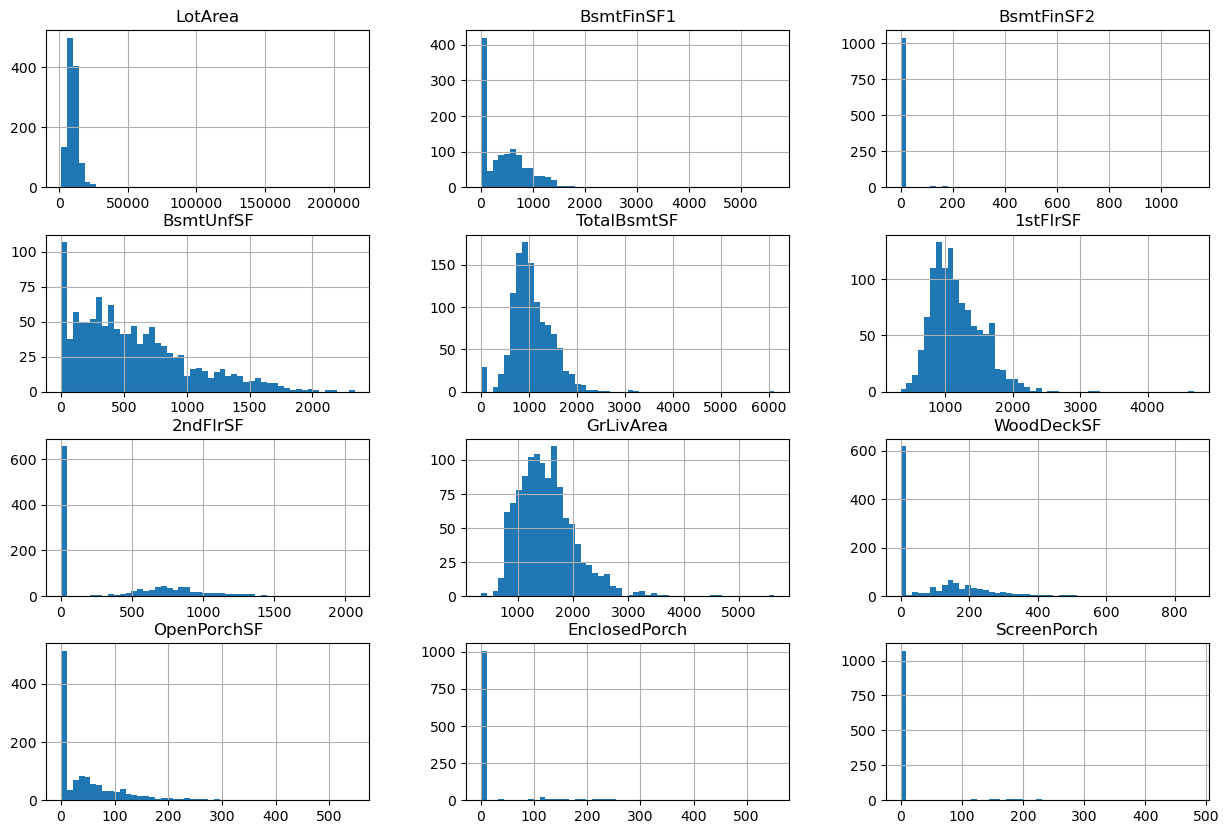

In [13]:
# Show the histograms of positively skewed features before log1p transformation
skewed_pos_cols = preprocess_result['skewed_pos_cols']
X_train[skewed_pos_cols].hist(bins=50, figsize=(15, 10));

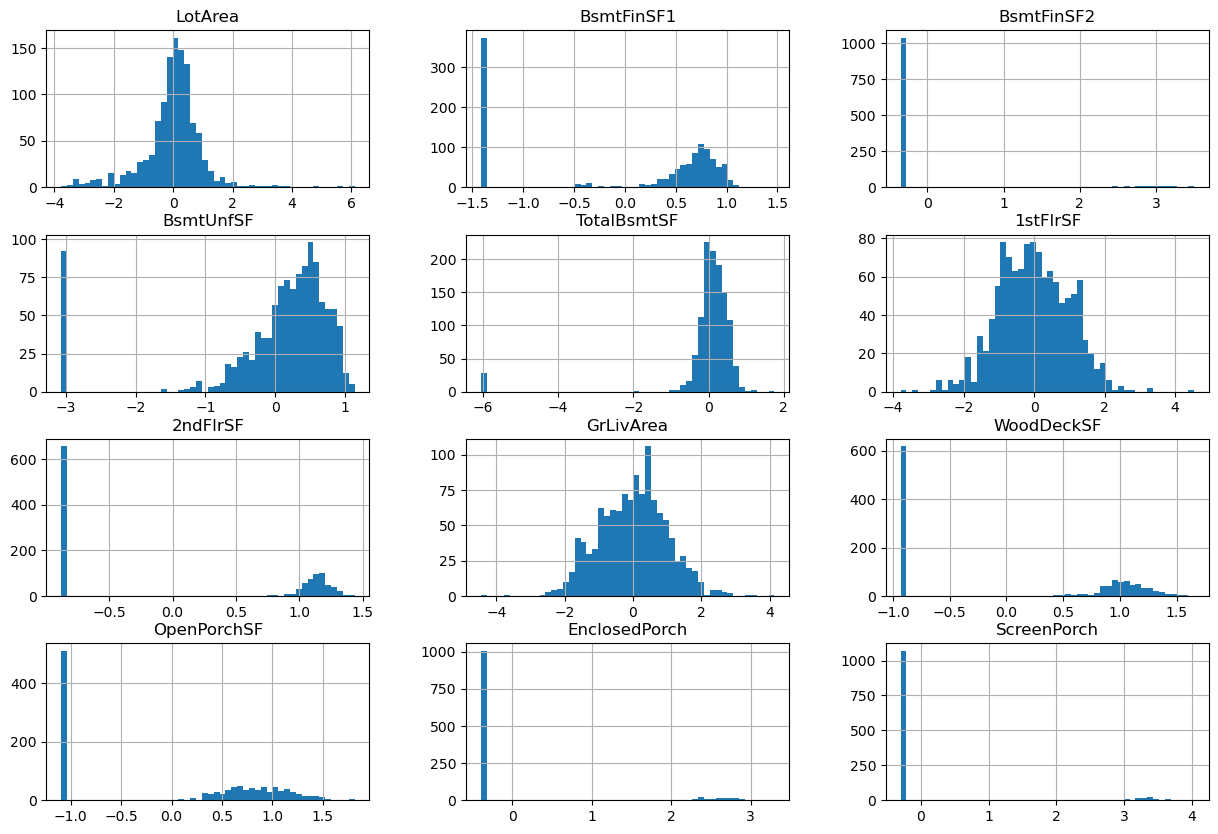

In [14]:
# Show the histograms of positively skewed features after log1p transformation and scaling
X_train_processed = preprocess_result['df_processed']
skewed_pos_cols = preprocess_result['skewed_pos_cols']
X_train_processed[skewed_pos_cols].hist(bins=50, figsize=(15, 10));

### Show histograms of negatively skewed features before and after transforming with sqrt

The following sections show that using the sqrt transform on negatively skewed features does not improve normality very much. Therefore we will not use transformation of negatively skewed features in a later section when we preprocess the features in the model training workflow.

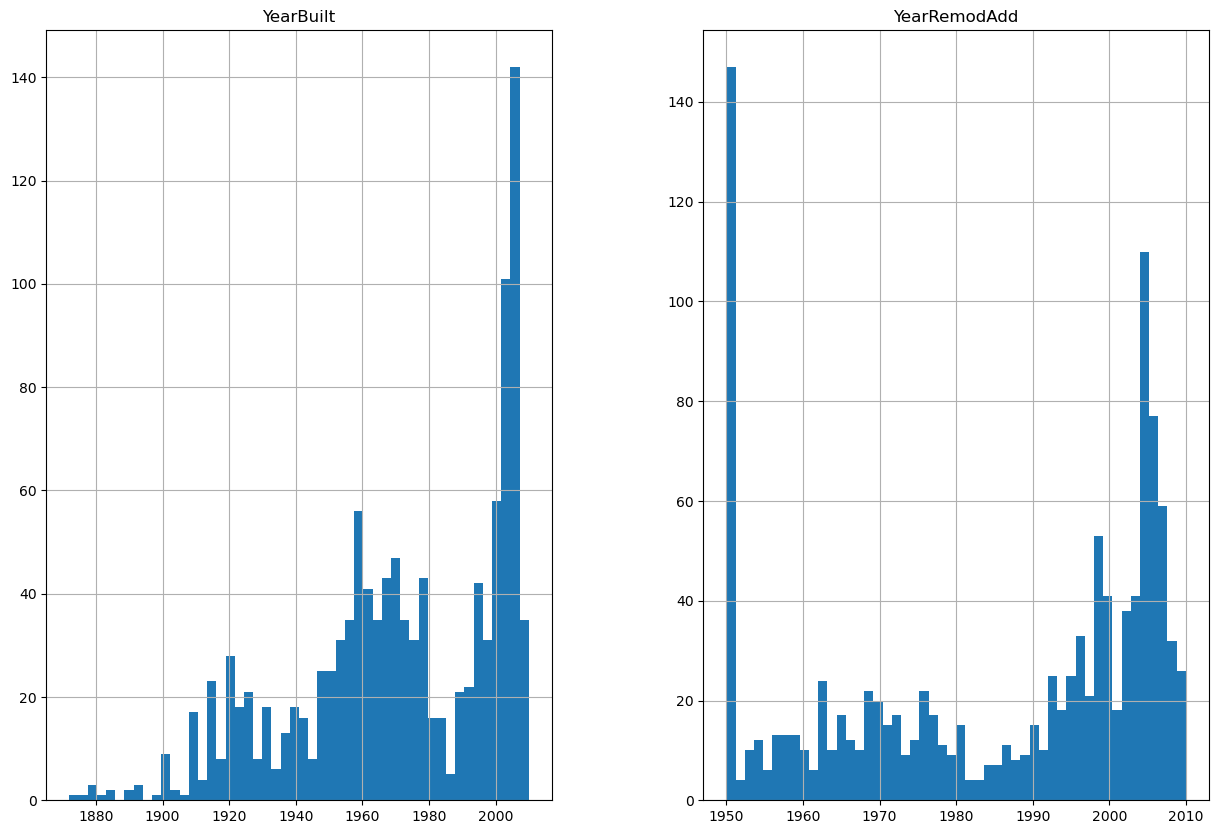

In [15]:
# histograms before unskew_neg
skewed_neg_cols = preprocess_result['skewed_neg_cols']
X_train[skewed_neg_cols].hist(bins=50, figsize=(15, 10));

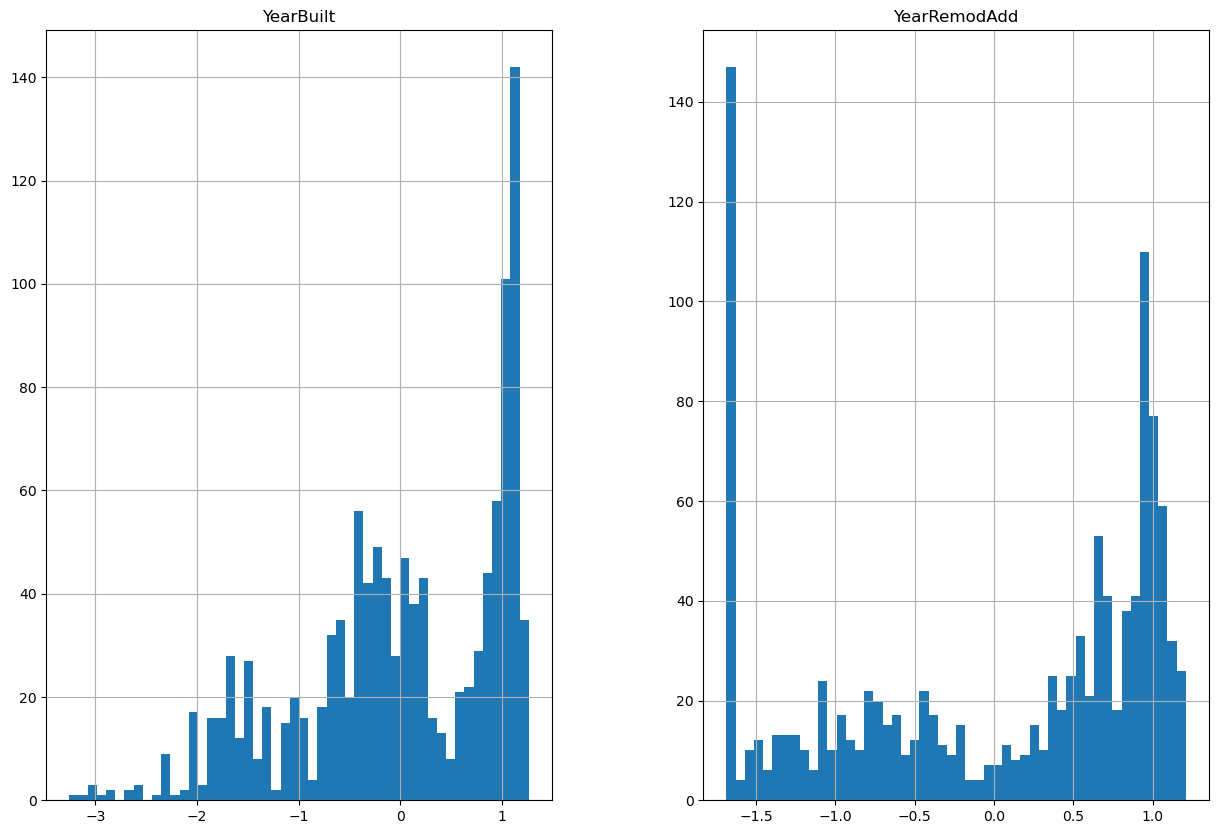

In [16]:
skewed_neg_cols = preprocess_result['skewed_neg_cols']
X_train_processed[skewed_neg_cols].hist(bins=50, figsize=(15, 10));

# Train the model with the training data subset

In the next step, we will train the model using the XGBoost regressor with the **xgb_auto** function of PyMLR. This step automatically finds the best cross-validated hyper-parameters for XGBoost using optuna. 

After this training step is completed, proceed to the next step to check how well the predictions from the training data match the predictions using the testing data. 

The **xgb_auto** function has the option to automatically use **preprocess_train** on X_train. We will use the argument preprocess=True to activate that option, and also use uskew_pos=True to specify that the positively skewed features will be log1p-transformed. We will also use optuna to select the optimum set of features with the argument feature_selection=True 

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting XGBRegressor model with best parameters, please wait ...

XGBRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   XGBRegressor |
|:-------------------|---------------:|
| R-squared          |    0.974823    |
| MSE                |    0.00383812  |
| RMSE               |    0.0619526   |
| Explained Variance |    0.974823    |
| MAE                |    0.043982    |
| Max Error          |    0.477685    |
| MAPE               |    0.0036742   |
| MSLE               |    2.30865e-05 |
| n_samples          | 1168           |

Done
Time elapsed: 1009.57 sec



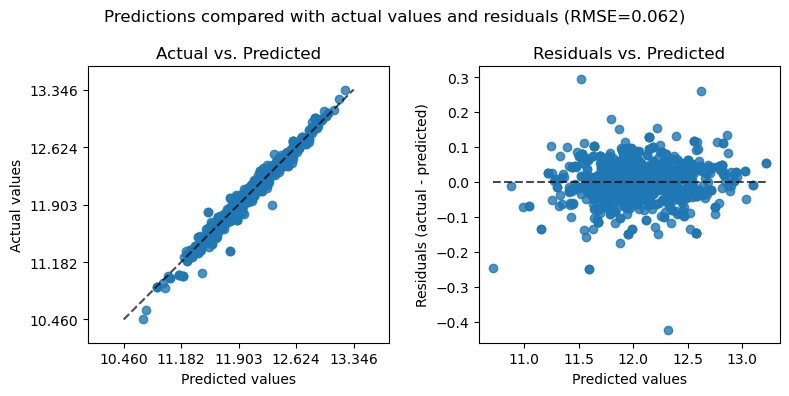

In [17]:
# optional keyword arguments
kwargs = {
    # [min, max] range of params that are optimized by optuna
    'preprocess': True,             # use preprocess_train to preprocess X_train
    'unskew_pos': True,             # unskew positively skewed features wth log1p
    'feature_selection': True,      # optuna feature selection
    'random_state': 42,             # random seed for reproducibility
    'n_trials': 50,                 # number of optuna trials
    'learning_rate': [1e-4, 1.0],   # step size shrinkage (also called eta)
    'max_depth': [3, 12],           # maximum depth of a tree
    'min_child_weight': [1, 10],    # minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 1],          # fraction of samples used for training each tree
    'colsample_bytree': [0.5, 1],   # fraction of features used for each tree
    'gamma': [1e-8, 10.0],          # minimum loss reduction to make a split
    'reg_lambda': [1e-8, 10.0],     # L2 regularization term on weights
    'alpha': [1e-8, 10.0],          # L1 regularization term on weights
    'n_estimators': [100, 1000]     # number of boosting rounds (trees)
}    

from PyMLR import xgb_auto
train_model, train_output = xgb_auto(X_train, y_train, **kwargs)

# Test the model with the testing data subset

In the next step we will check how well the predictions from fitted model match samples from the testing data. To standardize and encode the testing data we will use the same preprocess_result scaler and encoder that were used to standardize and encode the training data to avoid data leakage between the training and testing data. We will also use the same optimized selected features that were determined during the training. We will also transform the same set of positively skewed features. All of the information needed to transform, scale, and encode features is passed in the preprocess_results argument.


Goodness of fit to testing data in result['metrics']:

| Statistic          |    Regressor |
|:-------------------|-------------:|
| R-squared          |   0.897124   |
| MSE                |   0.0191978  |
| RMSE               |   0.138556   |
| Explained Variance |   0.897588   |
| MAE                |   0.0904174  |
| Max Error          |   0.894081   |
| MAPE               |   0.0076268  |
| MSLE               |   0.00011971 |
| n_samples          | 292          |



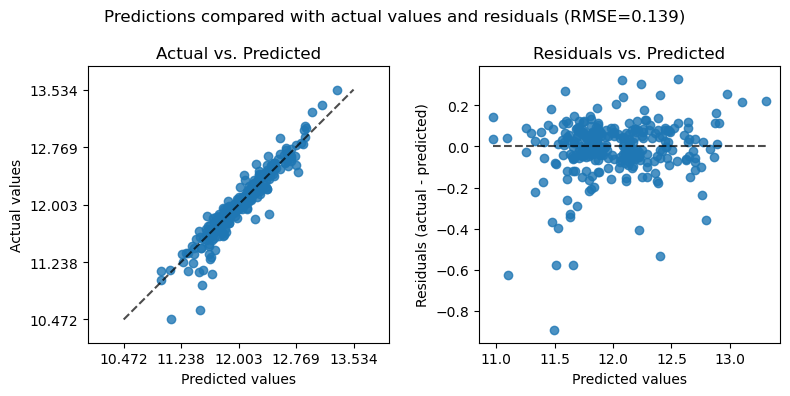

In [18]:
from PyMLR import test_model
test_output = test_model(train_model, X_test, y_test, 
    preprocess_result= train_output['preprocess_result'],
    selected_features= train_output['selected_features'])

# save the plot of predictions vs actual and residuals
test_output['fig'].savefig("XGBRegressor_predictions_test.png", dpi=300)

## Final fit of the model using all of the X and y data

In the next step we will use the optimum hyperparameters and selected features from the training model and fit the model using all of the X and y data. The standard scaler and encoder are recalculated by default (the user also has the option to input a previously calculated scaler/encoder from a previous preprocess_result).

Fitting XGBRegressor model, please wait ...


XGBRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   XGBRegressor |
|:-------------------|---------------:|
| R-squared          |    0.972304    |
| MSE                |    0.00441613  |
| RMSE               |    0.066454    |
| Explained Variance |    0.972304    |
| MAE                |    0.0472933   |
| Max Error          |    0.495669    |
| MAPE               |    0.00395437  |
| MSLE               |    2.66264e-05 |
| n_samples          | 1460           |

Done
Time elapsed: 2.79 sec



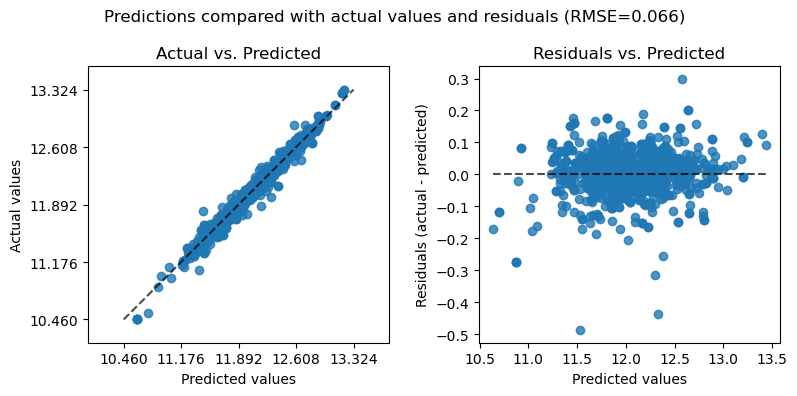

In [22]:
from PyMLR import xgb
final_model, final_output = xgb(X, log1p_y, unskew_pos=True,
    **train_output['best_params'],
    selected_features= train_output['selected_features'])

# Display the results of the hyperparameter optimization

The results of the optuna optimization study were saved in the previous step when the model was trained with the training data subset. The output dictionary that we called **train_output** in that step contains a key named **optuna_study** which contains the results of the optimized optuna study. 

In the next step we will use the **show_optuna** function to display the results of the optimized cross-validated optuna study to show the selected optimum values for the hyperparameters, the optimization history, and the relationships between the hyperparameters and their importance for the scoring criteria.

Best parameters:

learning_rate: 0.025353709669033966
max_depth: 5
min_child_weight: 8
subsample: 0.5734294285806886
colsample_bytree: 0.5717782556708967
gamma: 1.7639736167123274e-07
reg_lambda: 0.7657532602953884
alpha: 5.512611829404714e-06
n_estimators: 641
num_features: 223
selector_type: f_regression

Best score: -0.12433616093949976



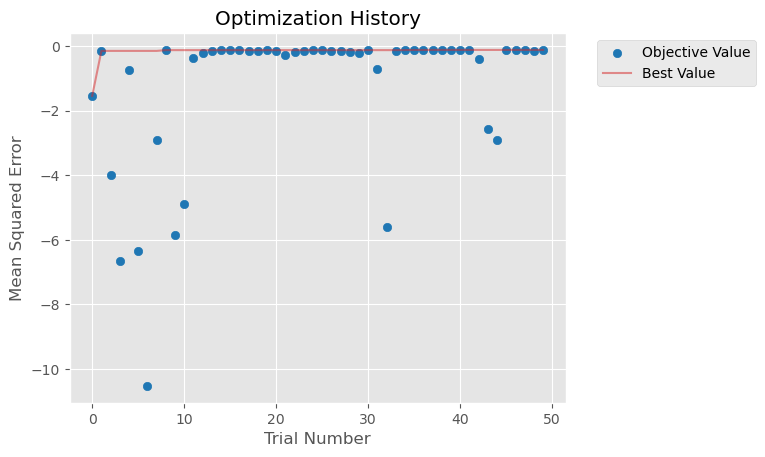

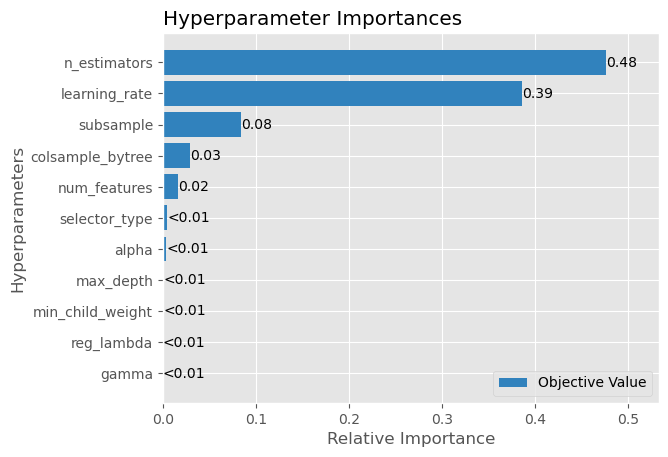

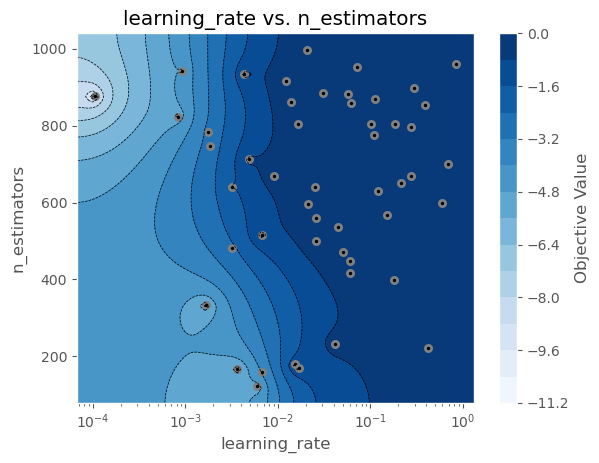

In [25]:
from PyMLR import show_optuna
show_optuna(train_output['optuna_study'])